In [1]:
import os, math, random
import numpy as np, pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Tuple, List
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from datasets import load_dataset

/home/coder/master/ikt469/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# reproducilbity
def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [3]:
def set_mpl_params(dpi: int = 200, figsize: Tuple[int, int] = (9, 6), grid: bool = True, font_size: int = 12, font_family: str = 'serif') -> None:
    mpl.rcParams['figure.dpi'] = dpi
    mpl.rcParams['figure.figsize'] = figsize
    mpl.rcParams['axes.grid'] = grid
    mpl.rcParams.update({'font.size': font_size})
    mpl.rcParams['font.family'] = font_family

In [4]:
@dataclass
class Config:
    model_name: str = "distilgpt2"
    batch_size: int = 16
    grad_accum_steps: int = 2
    epochs: int = 3
    lr: float = 0.001
    weight_decay: float = 0.0
    max_len: int = 256
    val_split: float = 0.2
    seed: int = 42
    warmup_ratio: float = 0.1

In [5]:
cfg = Config()
set_mpl_params()
seed_everything(cfg.seed)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
print("device:", DEVICE)

device: cuda


In [7]:
import urllib.request
import zipfile

URL = "https://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip"
DATA_DIR = "cornell_movie_dialogs"

os.makedirs(DATA_DIR, exist_ok=True)

zip_path = os.path.join(DATA_DIR, "cornell.zip")
urllib.request.urlretrieve(URL, zip_path)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(DATA_DIR)

print("Dataset downloaded and extracted.")

Dataset downloaded and extracted.


In [8]:
def load_lines(file_path):
    lines = {}
    with open(file_path, encoding="iso-8859-1") as f:
        for line in f:
            parts = line.strip().split(" +++$+++ ")
            if len(parts) == 5:
                line_id = parts[0]
                text = parts[4]
                lines[line_id] = text
    return lines

lines = load_lines(
    os.path.join(DATA_DIR, "cornell movie-dialogs corpus", "movie_lines.txt")
)

print(f"Loaded {len(lines)} lines.")


Loaded 304446 lines.


In [9]:
import ast

def load_conversations(file_path, lines):
    pairs = []
    with open(file_path, encoding="iso-8859-1") as f:
        for line in f:
            parts = line.strip().split(" +++$+++ ")
            if len(parts) == 4:
                line_ids = ast.literal_eval(parts[3])
                for i in range(len(line_ids) - 1):
                    input_line = lines.get(line_ids[i])
                    target_line = lines.get(line_ids[i + 1])
                    if input_line and target_line:
                        pairs.append((input_line, target_line))
    return pairs

pairs = load_conversations(
    os.path.join(DATA_DIR, "cornell movie-dialogs corpus", "movie_conversations.txt"),
    lines
)

print(f"Conversation pairs: {len(pairs)}")

Conversation pairs: 221282


In [10]:
tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(cfg.model_name)

In [11]:
# cornell pairs
def format_example(pair):
    return pair[0] + tokenizer.eos_token + pair[1] + tokenizer.eos_token


In [12]:
def tokenize_examples(texts):
    return tokenizer(texts, truncation=True, max_length=cfg.max_len, padding="max_length")

In [13]:
texts = [format_example(p) for p in pairs]
encodings = tokenize_examples(texts)

In [14]:
indices = list(range(len(encodings["input_ids"])))

train_idx, val_idx = train_test_split(indices, test_size=cfg.val_split, random_state=cfg.seed)

def subset_encodings(encodings, indices):
    return {k: [v[i] for i in indices] for k, v in encodings.items()}

train_enc = subset_encodings(encodings, train_idx)
val_enc = subset_encodings(encodings, val_idx)


In [15]:
class DialogDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = item["input_ids"].clone()
        return item

In [16]:
train_dataset = DialogDataset(train_enc)
val_dataset = DialogDataset(val_enc)
train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False)

In [17]:
model.to(DEVICE)
optimizer = AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
num_training_steps = (len(train_loader) // cfg.grad_accum_steps) * cfg.epochs
num_warmup_steps = int(cfg.warmup_ratio * num_training_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

In [ ]:
from tqdm import tqdm

train_losses = []
val_losses = []

for epoch in range(cfg.epochs):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for step, batch in enumerate(progress):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss / cfg.grad_accum_steps
        loss.backward()

        if (step + 1) % cfg.grad_accum_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * cfg.grad_accum_steps
        progress.set_postfix(loss=total_loss / (step + 1))

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}, train loss: {avg_train_loss:.4f}")
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, val loss: {avg_val_loss:.4f}")

Epoch 1:   0%|          | 13/11065 [00:02<35:58,  5.12it/s, loss=11.9] 

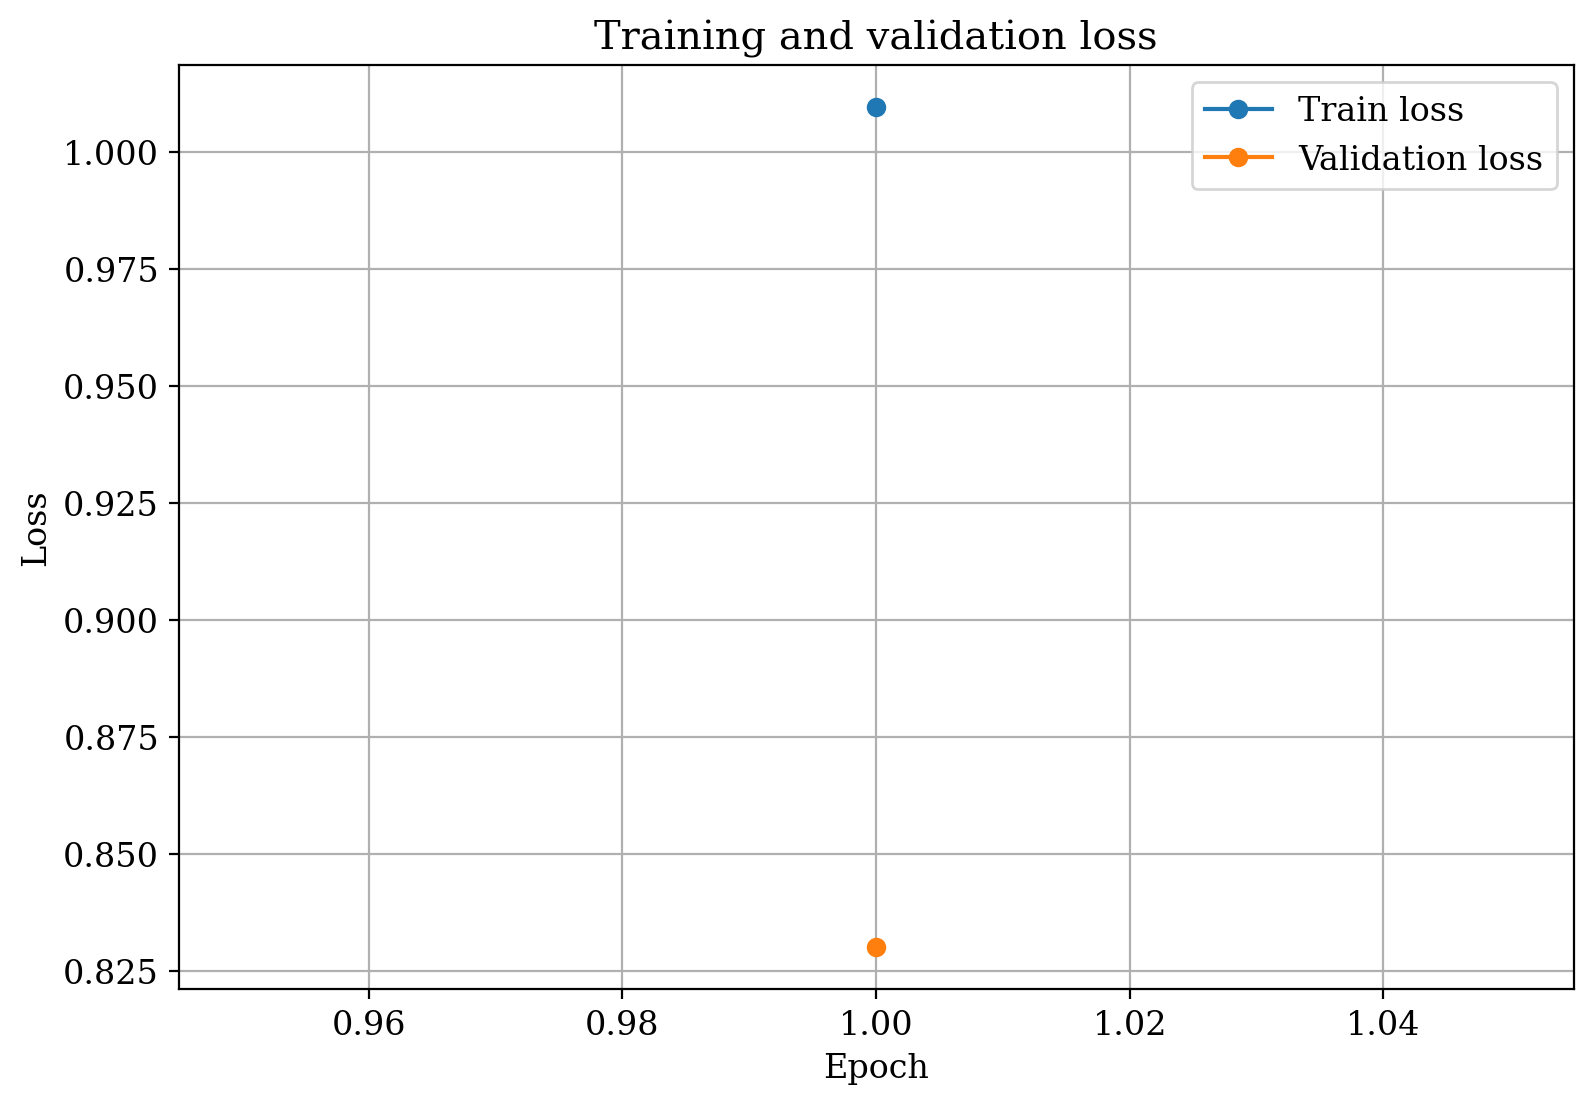

<Figure size 1800x1200 with 0 Axes>

In [ ]:
set_mpl_params()

plt.plot(range(1, cfg.epochs+1), train_losses, marker='o', label='Train loss')
plt.plot(range(1, cfg.epochs+1), val_losses, marker='o', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.savefig("trainvalplot.png")

In [ ]:
import seaborn as sns

def show_attention(text: str, layer_idx: int = 0, head_idx: int = 0):
    model.eval()
    tokens = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
    outputs = model(tokens, output_attentions=True)
    attn = outputs.attentions[layer_idx][0, head_idx].detach().cpu()
    token_labels = tokenizer.convert_ids_to_tokens(tokens[0])
    
    plt.figure(figsize=(10,8))
    sns.heatmap(attn, xticklabels=token_labels, yticklabels=token_labels, cmap='viridis')
    plt.title(f'Attention - Layer {layer_idx+1}, Head {head_idx+1}')
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.show()
    plt.savefig("attention.png")

TypeError: 'NoneType' object is not subscriptable

In [ ]:
model.save_pretrained("./moviebot_model")
tokenizer.save_pretrained("./moviebot_model")

('./moviebot_model/tokenizer_config.json',
 './moviebot_model/special_tokens_map.json',
 './moviebot_model/vocab.json',
 './moviebot_model/merges.txt',
 './moviebot_model/added_tokens.json',
 './moviebot_model/tokenizer.json')

In [ ]:
star_wars_questions = [
    "Who trained Luke Skywalker as a Jedi?",
    "What is the name of Darth Vader's ship?",
    "Which planet is Princess Leia from?",
    "Who said 'Do or do not, there is no try'?",
    "What color is Yoda's lightsaber?"
]

def generate_response(user_input: str, max_len: int = 50):
    model.eval()
    input_ids = tokenizer.encode(user_input + tokenizer.eos_token, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_length=max_len,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            top_k=50,
            top_p=0.95,
            temperature=0.8
        )
    response = tokenizer.decode(output_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)
    return response

for q in star_wars_questions:
    ans = generate_response(q)
    print(f"Q: {q}")
    print(f"A: {ans}\n")

Q: Who trained Luke Skywalker as a Jedi?
A: I'm not.

Q: What is the name of Darth Vader's ship?
A: The name of the ship.

Q: Which planet is Princess Leia from?
A: Yes.

Q: Who said 'Do or do not, there is no try'?
A: I don't know.

Q: What color is Yoda's lightsaber?
A: Yoda's lightsaber.



In [ ]:
def chat_step(user_input: str):
    response = generate_response(user_input)
    print(f"Bot: {response}\n")

chat_step("Answer questions about Star Wars movies accurately. Who is Rey?")
chat_step("Tell me about the Millennium Falcon.")

Bot: My dad is a Jedi.

Bot: So, what did you say?

